In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Task 1

In [41]:
class DenseLayer:
    def __init__(self, neurons=64, activation='sigmoid'):
        self.neurons = neurons
        self.activation = activation
        self.weights = None
        self.biases = None

    def activation_call(self, x, act, derivative=False):
        if not derivative:
            if act == 'sigmoid':
                return 1 / (1 + np.exp(-x))
            elif act == 'relu':
                return np.maximum(0, x)
        else:
            if act == 'sigmoid':
                sigmoid = 1 / (1 + np.exp(-x))
                return sigmoid * (1 - sigmoid)
            elif act == 'relu':
                return np.where(x > 0, 1, 0)

    def initialize_weights(self, input_size):
        self.weights = np.random.randn(input_size, self.neurons) * 0.01
        self.biases = np.zeros((1, self.neurons))

    def forward(self, X):
        self.input = X
        self.z = np.dot(X, self.weights) + self.biases
        self.output = self.activation_call(self.z, self.activation)
        return self.output

In [42]:
class Densenetwork:
    def __init__(self, lr=0.001, layers=None, epoch=10, batch_size=5):
        self.lr = lr
        self.layers = layers
        self.epoch = epoch
        self.batch_size = batch_size

    def backward(self, X, y, activations, zs):
        m = X.shape[0]
        dA = (activations[-1] - y) / m
        for layer in reversed(range(len(self.layers))):
            dZ = dA * self.layers[layer].activation_call(zs[layer], self.layers[layer].activation, derivative=True)
            dW = np.dot(activations[layer].T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, self.layers[layer].weights.T)
            self.layers[layer].weights -= self.lr * dW / X.shape[0]
            self.layers[layer].biases -= self.lr * db / X.shape[0]

    def call(self, X, y=None, training=True):
        if training:
            costs = []
            for epoch in range(self.epoch):
                cost = 0
                for i in range(0, X.shape[0], self.batch_size):
                    X_batch = X[i:i+self.batch_size]
                    y_batch = y[i:i+self.batch_size]
                    activations = [X_batch]
                    zs = []
                    for layer in self.layers:
                        if layer.weights is None:
                            layer.initialize_weights(activations[-1].shape[1])
                        z = layer.forward(activations[-1])
                        zs.append(z)
                        activations.append(z)
                    cost += np.mean((activations[-1] - y_batch) ** 2)
                    self.backward(X_batch, y_batch, activations, zs)
                cost /= X.shape[0]
                costs.append(cost)
                print(f"Epoch {epoch+1}/{self.epoch}, Loss: {cost}")
            return costs
        else:
            activations = [X]
            for layer in self.layers:
                activations.append(layer.forward(activations[-1]))
            return activations[-1]

In [51]:
X, y = make_regression(n_samples=100, n_features=10, noise=0.5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [52]:
layers = [DenseLayer(neurons=128, activation='relu'),
          DenseLayer(neurons=64, activation='relu'),
          DenseLayer(neurons=1, activation='sigmoid')]

In [53]:
network = Densenetwork(layers=layers, lr=0.01, epoch=100, batch_size=8)
losses = network.call(X_train, y_train)
predictions = network.call(X_test, training=False)

Epoch 1/100, Loss: 4588.12274637353
Epoch 2/100, Loss: 4588.122288698594
Epoch 3/100, Loss: 4588.121909745646
Epoch 4/100, Loss: 4588.121564410974
Epoch 5/100, Loss: 4588.121259473007
Epoch 6/100, Loss: 4588.120956899127
Epoch 7/100, Loss: 4588.120660295951
Epoch 8/100, Loss: 4588.120355879158
Epoch 9/100, Loss: 4588.120041263568
Epoch 10/100, Loss: 4588.119722685898
Epoch 11/100, Loss: 4588.1193933893355
Epoch 12/100, Loss: 4588.119055029796
Epoch 13/100, Loss: 4588.11868645696
Epoch 14/100, Loss: 4588.1182886737115
Epoch 15/100, Loss: 4588.117860619465
Epoch 16/100, Loss: 4588.117390913778
Epoch 17/100, Loss: 4588.116865683502
Epoch 18/100, Loss: 4588.116277073374
Epoch 19/100, Loss: 4588.115627554465
Epoch 20/100, Loss: 4588.114929698497
Epoch 21/100, Loss: 4588.114115640318
Epoch 22/100, Loss: 4588.113213578372
Epoch 23/100, Loss: 4588.112169878901
Epoch 24/100, Loss: 4588.110983918373
Epoch 25/100, Loss: 4588.109684316371
Epoch 26/100, Loss: 4588.1081230357395
Epoch 27/100, Loss: 

/var/folders/2c/tqnsgmld3sq49_grklfs06340000gn/T/ipykernel_41313/3215607368.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/2c/tqnsgmld3sq49_grklfs06340000gn/T/ipykernel_41313/4290914221.py:12: RuntimeWarning: invalid value encountered in multiply
  dZ = dA * self.layers[layer].activation_call(zs[layer], self.layers[layer].activation, derivative=True)
/Users/narinemarutyan/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


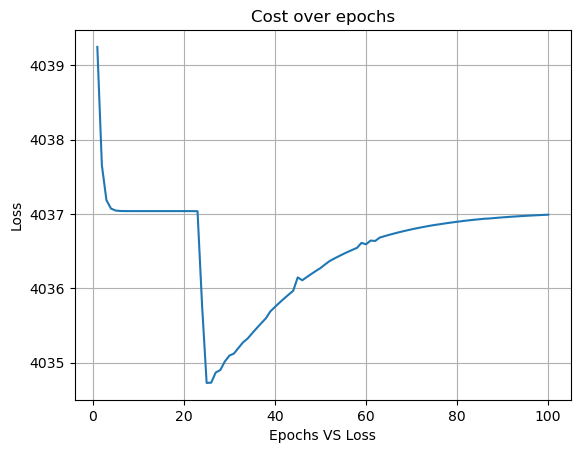

In [54]:
plt.plot(range(1, len(costs) + 1), costs)
plt.xlabel('Epochs VS Loss')
plt.ylabel('Loss')
plt.title('Cost over epochs')
plt.grid(visible=True)
plt.show()

## Task 2

In [48]:
class CustomDenseLayer(tf.Module):
    def __init__(self, input_dim, output_dim, activation=None):
        super(CustomDenseLayer, self).__init__()
        self.weights = tf.Variable(tf.random.normal([input_dim, output_dim]))
        self.biases = tf.Variable(tf.random.normal([output_dim]))
        self.activation = activation

    def __call__(self, x):
        z = tf.matmul(x, self.weights) + self.biases
        if self.activation == 'relu':
            return tf.nn.relu(z)
        elif self.activation == 'sigmoid':
            return tf.nn.sigmoid(z)
        else:
            return z

    def get_trainable_variables(self):
        return [self.weights, self.biases]

In [49]:
class CustomDenseNetwork(tf.Module):
    def __init__(self, input_dim, hidden_units, output_units, activations):
        super(CustomDenseNetwork, self).__init__()
        self.layers = []
        self.activations = activations
        for i, units in enumerate(hidden_units):
            layer = CustomDenseLayer(input_dim, units, activation=activations[i])
            self.layers.append(layer)
            input_dim = units

   
        self.output_layer = CustomDenseLayer(input_dim, output_units, activation=activations[-1])

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

    def get_trainable_variables(self):
        trainable_variables = []
        for layer in self.layers:
            trainable_variables.extend(layer.get_trainable_variables())
        trainable_variables.extend(self.output_layer.get_trainable_variables())
        return trainable_variables


In [55]:
input_dim = 2
hidden_units = [4, 3]
output_units = 1
activations = ['relu', 'relu', 'sigmoid']
tfn = CustomNetwork(input_dim, hidden_units, output_units, activations)

opt = tf.constant([[0.2, 0.4], [0.6, 0.8]])
print(tfn(opt))

tf.Tensor(
[[0.3043629 ]
 [0.27082145]], shape=(2, 1), dtype=float32)
